<a href="https://colab.research.google.com/github/guten-morgen3776/NN-numpy/blob/main/multi_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np

class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None #これから保存するから枠だけ作っておく

  def forward(self, x):
    self.x = x
    Z = np.dot(self.W, self.x) + self.b
    return Z

  def backward(self, dZ):
    m = self.x.shape[1] #入力行列の列数
    self.dW = np.dot(dZ, self.x.T) / m
    self.db = np.sum(dZ, axis=1, keepdims=True) / m
    dx = np.dot(self.W.T, dZ)
    return dx




In [52]:
#テスト

x = np.random.randn(2, 5)
W = np.random.randn(3, 2)
b = np.zeros((3, 1))

layer = Affine(W, b)
out = layer.forward(x)
print(out.shape)

dout = np.random.randn(3, 5)
dx = layer.backward(dout)
dW = layer.dW
db = layer.db
print(dW.shape)
print(db.shape)


(3, 5)
(3, 2)
(3, 1)


In [53]:
class Relu:
  def __init__(self):
    self.mask = None #順伝播と逆伝播を連動させるために0以下の場所をメモする

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dx = dout.copy()
    dx[self.mask] = 0
    return dx




In [54]:
#テスト
x = np.array([1, 3, -1])
relu = Relu()
out = relu.forward(x)
print(out)
print(relu.backward(out))

[1 3 0]
[1 3 0]


In [55]:
class sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1 - self.out) * self.out
    return dx



In [56]:
class Softmax:
  def __init__(self):
    self.out = None

  def forward(self, x):
    c = np.max(x, axis=0, keepdims=True)
    exp_x = np.exp(x - c)
    out = exp_x / np.sum(exp_x, axis=0, keepdims=True)
    self.out = out
    return out

  def backward(self, dout):
    return dout

In [57]:
from collections import OrderedDict

class MultiLayerNet:
  def __init__(self, input_size, hidden_size_list, output_size):
    self.params = {}
    self.layers = OrderedDict()
    all_size_list = [input_size] + hidden_size_list + [output_size]
    layer_num = len(all_size_list) - 1

    #層ごとの初期設定
    for idx in range(1, layer_num + 1):
      input_dim = all_size_list[idx - 1]
      output_dim = all_size_list[idx]
      W = np.random.randn(output_dim, input_dim) * 0.01
      b = np.zeros((output_dim, 1))

      self.params['W' + str(idx)] = W
      self.params['b' + str(idx)] = b

      self.layers['Affine' + str(idx)] = Affine(W, b)
      if idx == layer_num:
        self.layers['Softmax' + str(idx)] = Softmax()
      else:
        self.layers['Relu' + str(idx)] = Relu()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x

  def gradient(self, x, t):
    y = self.predict(x)
    dout = y - t
    layers = list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    for name, layer in self.layers.items():
      if isinstance(layer,Affine):
        idx = name[6:]
        grads['W' + idx] = layer.dW
        grads['b' + idx] = layer.db
    return grads


In [58]:
#小規模ネットワークで動作確認
simple_net = MultiLayerNet(input_size=2, hidden_size_list=[3], output_size=1)
x_dummy = np.random.randn(2, 2)
t_dummy = np.random.randn(1, 2)
grads = simple_net.gradient(x_dummy, t_dummy)
for key, val in grads.items():
  print(key, val)


W1 [[0. 0.]
 [0. 0.]
 [0. 0.]]
b1 [[0.]
 [0.]
 [0.]]
W2 [[0. 0. 0.]]
b2 [[1.51108647]]


In [59]:
import keras
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [60]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [61]:
#平らにして正規化
from tensorflow.keras.utils import to_categorical
x_train = train_X.reshape(60000, 784) / 255
x_test = test_X.reshape(10000, 784) / 255
t_train = to_categorical(train_y, 10)
t_test = to_categorical(test_y, 10)


In [62]:
def loss_function(y, t):
  loss = -np.sum(t * np.log(y + 1e-5)) / y.shape[1] #バッチサイズで正規化
  return loss

In [69]:
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iters_num = 10000

network = MultiLayerNet(input_size=784, hidden_size_list=[256, 128, 64], output_size=10)
iters = []
losses = []
#学習ループ
for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask].T
  t_batch = t_train[batch_mask].T

  grad = network.gradient(x_batch, t_batch)
  #パラメータ更新
  for key in network.params.keys():
    network.params[key] -= learning_rate * grad[key]

  if i % 1000 == 0:
    loss = loss_function(network.predict(x_batch), t_batch)
    iters.append(i)
    losses.append(loss)
    print(f'iteration{i}: loss = {loss}')

iteration0: loss = 2.3019406041281214
iteration1000: loss = 2.3009531735926747
iteration2000: loss = 0.6107322835801964
iteration3000: loss = 0.11132521576931349
iteration4000: loss = 0.03611673494583575
iteration5000: loss = 0.0302028608626516
iteration6000: loss = 0.02139851203467537
iteration7000: loss = 0.010947078536113063
iteration8000: loss = 0.013760244570291602
iteration9000: loss = 0.0027193925885321407


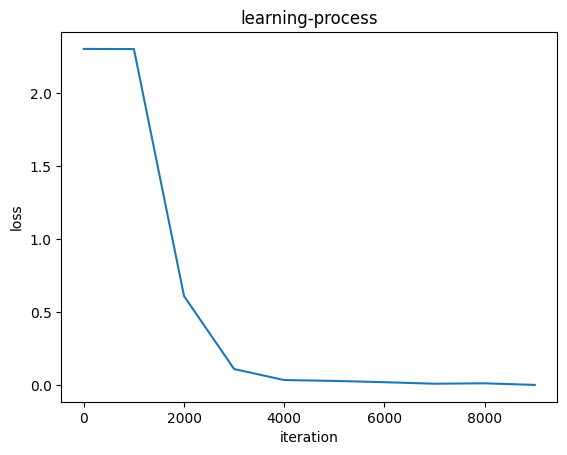

In [70]:
import matplotlib.pyplot as plt
plt.plot(iters, losses)
plt.title("learning-process")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [68]:
#検証
y_test = network.predict(x_test.T)

accuracy = np.mean(np.argmax(y_test, axis=0) == np.argmax(t_test, axis=1))
print(f'accuracy = {accuracy}')

accuracy = 0.9764
